In [25]:
import os
import numpy as np
import tensorflow as tf
import cv2

In [26]:
from matplotlib import pyplot as plt

In [27]:
import keras

In [28]:
!pip install segmentation-models
!pip install patchify

In [29]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [30]:
import segmentation_models as sm

In [31]:
from tensorflow.keras.metrics import MeanIoU

In [32]:
from patchify import patchify
from PIL import Image
from PIL import ImageEnhance

In [33]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [34]:
#this is the directory where there must two folders which hold true images and masks respectively

root_directory = '/content/drive/MyDrive/Research/Dataset/test'

In [35]:
patch_size = 512

In [36]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images_ir':   #REPLACE WITH THE FOLDER NAME WITH TRUE IMAGES
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):   #Only read png images

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner

                img_enhancer = ImageEnhance.Brightness(image)
                factor = 1.5
                enhanced_output = img_enhancer.enhance(factor)
                image = enhanced_output

                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name, len(image_dataset))
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=512 for 512 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 511.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255. --> Only for debug
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)

Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/0.png 0
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/1.png 6
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/10.png 21
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/100.png 24
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/101.png 36
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/102.png 51
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/103.png 66
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/104.png 81
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/105.png 96
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/106.png 111
Now patchifying image: /content/drive/MyDrive/Research/Dataset/test/images_ir/11.png 126
Now patchifying image: /con

In [37]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #REPLACE WITH THE FOLDER NAME WITH MASK IMAGES
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images (masks in this dataset)

                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name, len(mask_dataset))
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=512 for 512 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/0.png 0
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/1.png 6
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/10.png 21
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/100.png 24
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/101.png 36
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/102.png 51
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/103.png 66
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/104.png 81
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/105.png 96
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/106.png 111
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/11.png 126
Now patchifying mask: /content/drive/MyDrive/Research/Dataset/test/masks/12.png 12

In [38]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

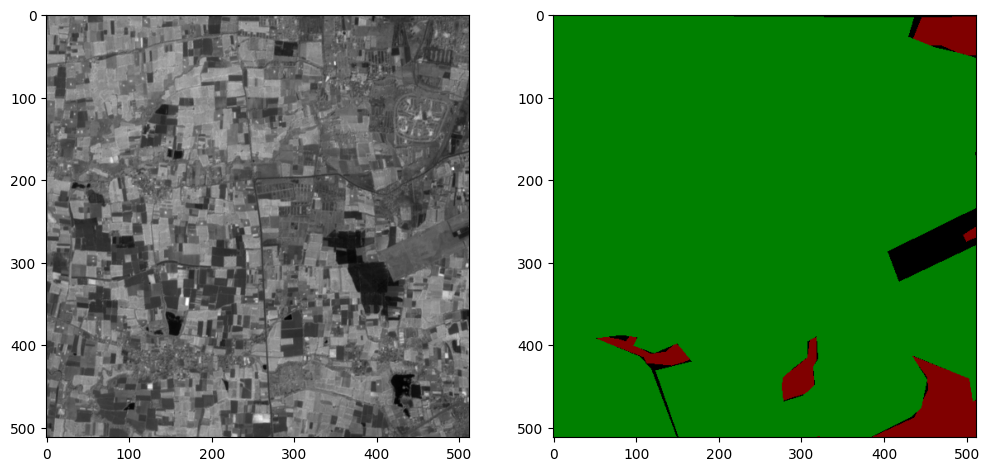

290


In [39]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()
print(image_number)

In [40]:
#Put corresponding RGB HEX codes for the labels in the mask images

Builtup = '#800000'.lstrip('#')
Builtup = np.array(tuple(int(Builtup[i:i+2], 16) for i in (0, 2, 4))) # 128,0,0

Vegetation = '#008000'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #0,128,0

Water = '808000'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #128,128,0

Unlabeled = '#000000'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [41]:
label = single_patch_mask

In [42]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values.
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Builtup,axis=-1)] = 0
    label_seg [np.all(label==Vegetation,axis=-1)] = 1
    label_seg [np.all(label==Water,axis=-1)] = 2
    label_seg[np.all(label == Unlabeled, axis=-1)] = 3
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

In [43]:
def set_labels(mask_dataset):
    labels = []
    for i in range(mask_dataset.shape[0]):
        label = rgb_to_2D_label(mask_dataset[i])
        labels.append(label)

    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=3)

    print("Unique labels in label dataset are: ", np.unique(labels))
    n_classes = len(np.unique(labels))
    from tensorflow.keras.utils import to_categorical
    labels_cat = to_categorical(labels, num_classes=n_classes)


    return labels_cat

In [44]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [45]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3]


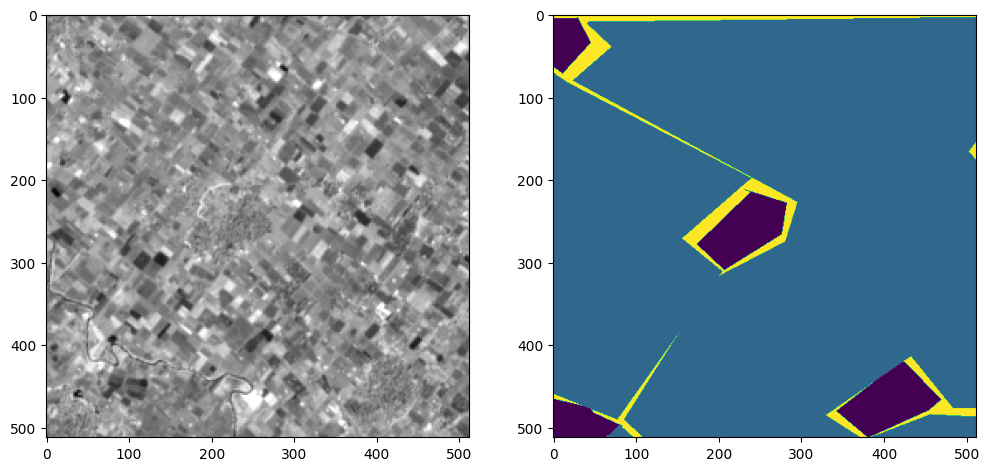

173


In [46]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()
print(image_number)

In [47]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [49]:
weights = [0.25, 0.25, 0.25, 0.25]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

In [50]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [51]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [52]:
#from keras.models import Model
#from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
#from keras import layers as K
#from keras.layers import Flatten

In [53]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [54]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)

    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    #Expansive path

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)  # Original 0.1
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)  # Original 0.1
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [55]:
metrics=['accuracy', jacard_coef]

In [56]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [57]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [58]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50
22/22 [==============================] - 34s 655ms/step - loss: 0.9845 - accuracy: 0.2817 - jacard_coef: 0.1648 - val_loss: 0.9788 - val_accuracy: 0.2821 - val_jacard_coef: 0.1575
Epoch 2/50
22/22 [==============================] - 6s 268ms/step - loss: 0.9737 - accuracy: 0.3127 - jacard_coef: 0.1780 - val_loss: 0.9751 - val_accuracy: 0.2884 - val_jacard_coef: 0.1636
Epoch 3/50
22/22 [==============================] - 6s 269ms/step - loss: 0.9730 - accuracy: 0.3516 - jacard_coef: 0.1774 - val_loss: 0.9723 - val_accuracy: 0.3882 - val_jacard_coef: 0.1706
Epoch 4/50
22/22 [==============================] - 6s 268ms/step - loss: 0.9584 - accuracy: 0.3683 - jacard_coef: 0.1971 - val_loss: 0.9415 - val_accuracy: 0.4138 - val_jacard_coef: 0.2413
Epoch 5/50
22/22 [==============================] - 6s 268ms/step - loss: 0.9488 - accuracy: 0.3891 - jacard_coef: 0.2151 - val_loss: 0.9393 - val_accuracy: 0.3987 - val_jacard_coef: 0.2405
Epoch 6/50
22/22 [==============================]

In [59]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [60]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [61]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

85521592/85521592 [==============================] - 0s 0us/step


In [62]:
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [63]:
print(model_resnet_backbone.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

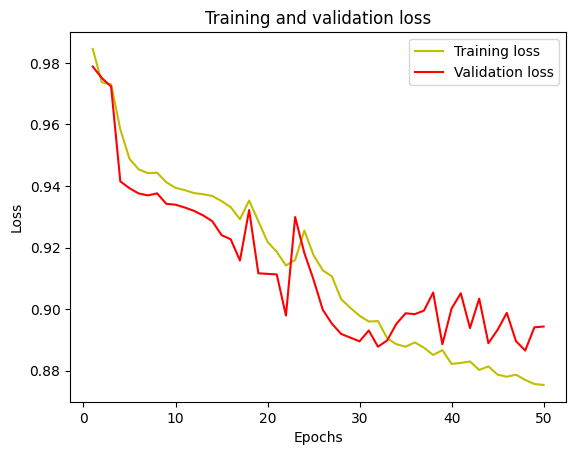

In [64]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

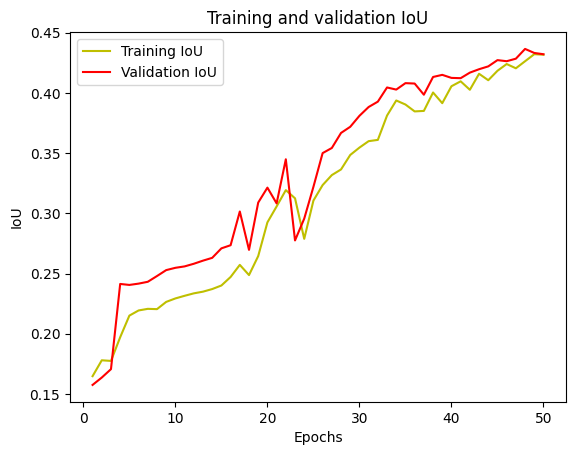

In [66]:
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [67]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

3/3 [==============================] - 9s 2s/step


In [68]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.49572682


In [83]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 20ms/step


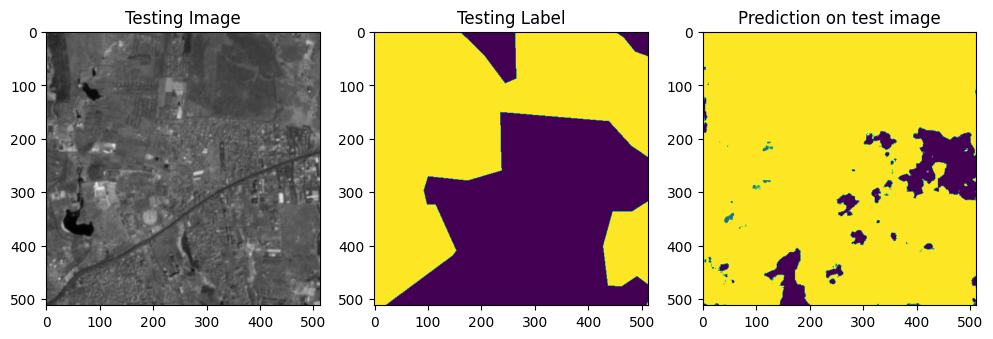

48


In [82]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
print(test_img_number)